# Spectrums

In [69]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import pprint
pp = pprint.PrettyPrinter(indent=4)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Import and intialize the Google Earth Engine Library
import ee
from gee_library import *
ee.Initialize()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
# First load an elevation dataset
# The USGS/NED set is not actually a ee.Collection; it's an ee.Image. But right now all of my helper function expect
# ee.Collection types. So we'll just package the Image into a Collection.
elevation_image = ee.Image('USGS/NED')
elevation_collection = ee.ImageCollection(elevation_image)

# It looks like there is 1 band available: 'elevation'.
available_bands_in_monterey = available_bands(elevation_collection)
for k, v in available_bands_in_monterey.items():
    print "Band", k, "is available in", v['number_available'], "images. (", v['percent_available'], "%)"

Band elevation is available in 1 images. ( 100 %)


{'elevation': './tmp/18533382/map_section.elevation.tif'}


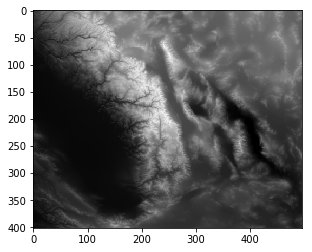

In [61]:
# We'll select an area 400km x 400km centered at Mt. Whitney
mt_whitney = (-118.292391, 36.578481)

tile_bounds = square_centered_at(
    point = mt_whitney,
    half_distance = 400e3/2
)

# Choosing a resolution of 1000 should result in an image with dimentions around 400x400
tiles = img_at_region(elevation_collection, 1000, ['elevation'], tile_bounds)
elevation_img = np.array(tiles['elevation'])
plt.imshow(elevation_img, cmap='gray'); plt.show()

Max value in elevation_img: 4226.08


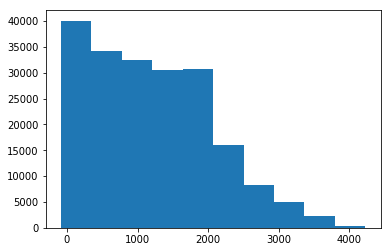

In [62]:
# This elevation data has some special properties. While most of the images we were looking at earlier
# contained pixels from 0-255 (8 bit color), the pixels in this image range from 0-4226.
print "Max value in elevation_img:", np.amax(elevation_img)
plt.hist(elevation_img.flatten())
plt.show()

# It's not a coincidence that Mt. Whitney measures just over 4km high. Each pixel value in the
# elevation tif represents meters.


elevation_img.shape: (402, 497)


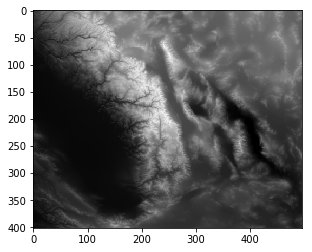

In [63]:
# Interestingly, the 'elevation' band is served to us as a 4-channel tif (unlike the RGB bands which are single channel.
print "elevation_img.shape:", elevation_img.shape

# When we look at each channel independantly we see that the first 3 are redundant, and the last layer (which defines
# transparency) is set to fully opaque.
plt.imshow(elevation_img, cmap='gray'); plt.show()


{'B': './tmp/4974170/map_section.B.tif', 'R': './tmp/4974170/map_section.R.tif', 'G': './tmp/4974170/map_section.G.tif'}


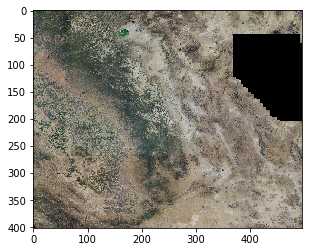

In [64]:
# Now let's pull the RGB imagery of the same region. Since USGS/NED only has elevation imagery, we have to
# load a differt ImageCollection that has the RGB bands. Luckily, since all the images in the GEE are tagged
# with accurate GPS and projection information, we can fuse different datasets together.

rgb_collection = ee.ImageCollection('USDA/NAIP/DOQQ').filterBounds(tile_bounds).filter(ee.Filter.date('2015-01-01', '2017-01-10'))

tiles = img_at_region(rgb_collection, 1000, ['R', 'G', 'B'], tile_bounds)
rgb_img = np.dstack((tiles['R'], tiles['G'], tiles['B']))
plt.imshow(rgb_img); plt.show()

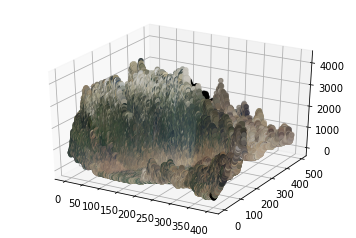

In [72]:
# At this point we have two arrays with the same x,y dimentions. Each value in elevation_img is a measurement in
# meters, while each element in rgb_img is an (R,B,G) tuple. From here we might stack them, creating an (R,B,G,elevation)
# tuple and do some statistics on them (more on that later). To visualize it, however, we will transform the pixels
# into a 3D point cloud.
from mpl_toolkits.mplot3d import Axes3D

xs = []
ys = []
zs = []
cs = []

# For every element in the images, save the x value, y value, elevation, and color.
# There are more efficient ways to do this, but I thought this was the easiest to comprehend.
for x in range(elevation_img.shape[0]):
    for y in range(elevation_img.shape[1]):
        xs.append(x)
        ys.append(y)
        zs.append(elevation_img[x,y])
        cs.append([
            rgb_img[x,y][0]/255.0, rgb_img[x,y][1]/255.0, rgb_img[x,y][2]/255.0, 1.0
        ])
    
# Plot the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=xs, ys=ys, zs=zs, facecolors=cs)
plt.show()
